In [148]:
import numpy as np
import rasterio as rio
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.ops import cascaded_union
from shapely.geometry.polygon import Polygon
from cartopy.feature import ShapelyFeature
import matplotlib.patches as mpatches

In [149]:
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

In [150]:
def percentile_stretch(img, pmin=0., pmax=100.):
    '''
    This is where you should write a docstring.
    '''
    # here, we make sure that pmin < pmax, and that they are between 0, 100
    if not 0 <= pmin < pmax <= 100:
        raise ValueError('0 <= pmin < pmax <= 100')
    # here, we make sure that the image is only 2-dimensional
    if not img.ndim == 2:
        raise ValueError('Image can only have two dimensions (row, column)')

    minval = np.percentile(img, pmin)
    maxval = np.percentile(img, pmax)

    stretched = (img - minval) / (maxval - minval)  # stretch the image to 0, 1
    stretched[img < minval] = 0  # set anything less than minval to the new minimum, 0.
    stretched[img > maxval] = 1  # set anything greater than maxval to the new maximum, 1.

    return stretched

In [151]:
def img_display(img, ax, bands, stretch_args=None, **imshow_args):
    '''
    This is where you should write a docstring.
    '''
    dispimg = img.copy().astype(np.float32)  # make a copy of the original image,
    # but be sure to cast it as a floating-point image, rather than an integer

    for b in range(img.shape[0]):  # loop over each band, stretching using percentile_stretch()
        if stretch_args is None:  # if stretch_args is None, use the default values for percentile_stretch
            dispimg[b] = percentile_stretch(img[b])
        else:
            dispimg[b] = percentile_stretch(img[b], **stretch_args)

    # next, we transpose the image to re-order the indices
    dispimg = dispimg.transpose([1, 2, 0])

    # finally, we display the image
    handle = ax.imshow(dispimg[:, :, bands], **imshow_args)

    return handle, ax


In [152]:
# note - rasterio's open() function works in much the same way as python's - once we open a file,
# we have to make sure to close it. One easy way to do this in a script is by using the with statement shown
# below - once we get to the end of this statement, the file is closed.
with rio.open('data_files/NI_Mosaic.tif') as dataset:
    img = dataset.read()
    xmin, ymin, xmax, ymax = dataset.bounds

# your code goes here! show a map with county borders, town and city locations

# now all raster functions and tools and imported and functions are defined, we need to:
# check the raster info
# import vector layers, set CRS, and spatially join them
# determine a map view
# set myCRS
# call the raster functions/ show image
# 

In [153]:
#display raster information
print('{} openend in {} mode'.format(dataset.name,dataset.mode))
print('image has {} band(s)'.format(dataset.count))
print('image size (width, height): {} x {}'.format(dataset.width, dataset.height))
print('band 1 datatype is {}'.format(dataset.dtypes[0]))
print(dataset.bounds)
print(dataset.crs)

data_files/NI_Mosaic.tif openend in r mode
image has 7 band(s)
image size (width, height): 1850 x 1500
band 1 datatype is int16
BoundingBox(left=550000.0, bottom=5985000.0, right=735000.0, top=6135000.0)
EPSG:32629


In [154]:
#import vector data, check columns and CRS
wards = gpd.read_file('data_files/NI_wards.shp')
print(wards.head())
wards.crs

  Ward Code          Ward  Population  \
0    95DD05     Ballykeel        1739   
1    95DD06  Ballyloughan        2588   
2    95DD03      Ardeevin        3503   
3    95DD04        Ballee        1926   
4    95DD09  Craigywarren        2590   

                                            geometry  
0  POLYGON ((-6.25014 54.85879, -6.25015 54.85875...  
1  POLYGON ((-6.28913 54.86946, -6.28917 54.86949...  
2  POLYGON ((-6.29527 54.84752, -6.29527 54.84751...  
3  POLYGON ((-6.26087 54.84528, -6.26096 54.84524...  
4  POLYGON ((-6.24807 54.89652, -6.24819 54.89645...  


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [155]:
#import vector data, check columns and CRS
counties = gpd.read_file('data_files/counties.shp')
print(counties.head())
counties.crs

   COUNTY_ID   CountyName    Area_SqKM  OBJECTID  \
0          6       TYRONE  3265.796622         1   
1          1       ANTRIM  3097.847750         2   
2          2       ARMAGH  1327.228438         3   
3          4    FERMANAGH  1850.832538         4   
4          5  LONDONDERRY  2118.316853         5   

                                            geometry  
0  POLYGON ((-7.38177 54.94208, -7.38170 54.94201...  
1  MULTIPOLYGON (((-5.95296 54.55222, -5.95298 54...  
2  POLYGON ((-6.35398 54.50927, -6.35191 54.50891...  
3  POLYGON ((-7.69417 54.60511, -7.69390 54.60498...  
4  POLYGON ((-6.66919 55.19899, -6.66918 55.19893...  


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [156]:
#import vector data, check columns and CRS
towns = gpd.read_file('data_files/NI_towns.shp')
print(towns.head())
towns.crs

   TOWN_NAME  X_COORD  Y_COORD STATUS  town_city  \
0   Strabane   234500   397700   Town          0   
1     Antrim   315300   387000   Town          0   
2     Armagh   287600   345500   City          1   
3  Ballymena   310700   403400   Town          0   
4  Banbridge   312700   346200   Town          0   

                        geometry  
0  POINT (234500.000 397700.000)  
1  POINT (315300.000 387000.000)  
2  POINT (287600.000 345500.000)  
3  POINT (310700.000 403400.000)  
4  POINT (312700.000 346200.000)  


<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

In [157]:
#change CRS of vector datasets to match raster(UTM 29 EPGS32629)
counties=counties.to_crs(epsg=32629)
wards=wards.to_crs(epsg=32629)
towns=towns.to_crs(epsg=32629)

In [158]:
#check CRS of vector layers
counties.crs
wards.crs
towns.crs

<Projected CRS: EPSG:32629>
Name: WGS 84 / UTM zone 29N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°W and 6°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Côte D'Ivoire (Ivory Coast). Faroe Islands. Guinea. Ireland. Jan Mayen. Mali. Mauritania. Morocco. Portugal. Sierra Leone. Spain. United Kingdom (UK). Western Sahara.
- bounds: (-12.0, 0.0, -6.0, 84.0)
Coordinate Operation:
- name: UTM zone 29N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [159]:
#spatial join wards and counties vector layers
join_a =gpd.sjoin(wards, counties, how='inner')
join_a

,Ward Code,Ward,Population,geometry,index_right,COUNTY_ID,CountyName,Area_SqKM,OBJECTID
0,95DD05,Ballykeel,1739,"POLYGON ((676498.653 6082542.519, 676498.568 6...",1,1,ANTRIM,3097.847750,2
1,95DD06,Ballyloughan,2588,"POLYGON ((673950.756 6083631.429, 673948.575 6...",1,1,ANTRIM,3097.847750,2
2,95DD03,Ardeevin,3503,"POLYGON ((673651.117 6081176.579, 673651.458 6...",1,1,ANTRIM,3097.847750,2
3,95DD04,Ballee,1926,"POLYGON ((675868.902 6081012.723, 675863.587 6...",1,1,ANTRIM,3097.847750,2
4,95DD09,Craigywarren,2590,"POLYGON ((676466.958 6086744.901, 676459.166 6...",1,1,ANTRIM,3097.847750,2
...,...,...,...,...,...,...,...,...,...
484,95YY21,Trillick,2440,"POLYGON ((598939.476 6031249.507, 598926.483 6...",3,4,FERMANAGH,1850.832538,4
541,95OO09,Clogher,2252,"POLYGON ((619819.300 6032392.614, 619820.387 6...",3,4,FERMANAGH,1850.832538,4
560,95OO16,Fivemiletown,2114,"POLYGON ((615506.146 6029029.499, 615504.069 6...",3,4,FERMANAGH,1850.832538,4
567,95YY06,Dromore,2394,"POLYGON ((601078.425 6041989.510, 601079.435 6...",3,4,FERMANAGH,1850.832538,4


In [160]:
#drop the index_right column in order to do second join (python wont allow multiply columns by same name)
join_a.drop('index_right', axis=1, inplace=True)

In [161]:
#spatial join join_a to towns vector layer
join_b =gpd.sjoin(join_a, towns, how='inner')

In [162]:
print(join_b.head())

   Ward Code            Ward  Population  \
6     95DD08  Castle Demesne        2126   
15    95AA09   Fountain Hill        2220   
35    95QQ15      Town Parks        1593   
51    95GG39     Shaftesbury        7214   
51    95GG39     Shaftesbury        7214   

                                             geometry  COUNTY_ID CountyName  \
6   POLYGON ((675866.624 6083179.615, 675867.005 6...          1     ANTRIM   
15  POLYGON ((680606.389 6066437.737, 680607.071 6...          1     ANTRIM   
35  POLYGON ((704516.877 6083593.941, 704518.964 6...          1     ANTRIM   
51  POLYGON ((697769.859 6053115.587, 697761.455 6...          1     ANTRIM   
51  POLYGON ((697769.859 6053115.587, 697761.455 6...          3       DOWN   

      Area_SqKM  OBJECTID  index_right  TOWN_NAME  X_COORD  Y_COORD STATUS  \
6   3097.847750         2            3  Ballymena   310700   403400   Town   
15  3097.847750         2            1     Antrim   315300   387000   Town   
35  3097.847750         2 

In [163]:
#define my CRS
myCRS = ccrs.UTM(29) 

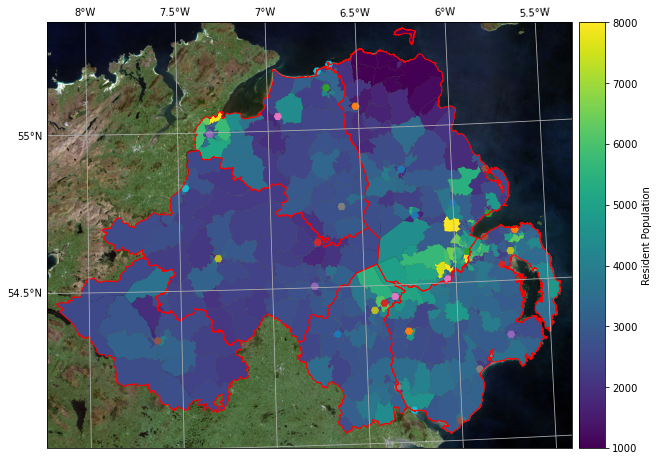

In [172]:
#display raster map
my_kwargs = {'extent': [xmin, xmax, ymin, ymax],
             'transform': myCRS}

my_stretch = {'pmin': 0.1, 'pmax': 99.9}

h, ax = img_display(img, ax, [2, 1, 0], stretch_args=my_stretch, **my_kwargs)
fig

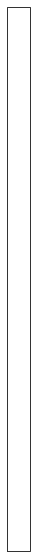

In [165]:
# create a figure of size 10x10 (representing the page size in inches
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=myCRS))

In [166]:
# add gridlines below
gridlines = ax.gridlines(draw_labels=True,
                         xlocs=[-8, -7.5, -7, -6.5, -6, -5.5],
                         ylocs=[54, 54.5, 55, 55.5])
gridlines.right_labels = False
gridlines.bottom_labels = False

In [167]:
# to make a nice colorbar that stays in line with our map, use these lines:
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)

In [168]:
# plot the vector data into our axis, using ax=ax places image on you axes
ward_plot = wards.plot(column='Population', ax=ax, vmin=1000, vmax=8000, cmap='viridis',
                       legend=True, cax=cax, legend_kwds={'label': 'Resident Population'})

county_outlines = ShapelyFeature(counties['geometry'], myCRS, edgecolor='r', facecolor='none')

<Figure size 432x288 with 0 Axes>

In [169]:
towns_plot = towns.plot(column='TOWN_NAME', ax=ax, marker = 'H', facecolor= 'green', markersize = 50)


<Figure size 432x288 with 0 Axes>

In [171]:
ax.add_feature(county_outlines)
county_handles = generate_handles([''], ['none'], edge='r')
towns_handles = generate_handles([''], ['none'], edge='g')

ax.legend(county_handles, ['County Boundaries'], town_handles, ['Towns'], fontsize=12, loc='upper left', framealpha=1)

# save the figure
# fig.savefig('sample_map.png', dpi=300, bbox_inches='tight')


TypeError: legend only accepts two non-keyword arguments